# Variables

In [1]:
ga_input = '/grid/home/nbourgeois/data/test_proteins/hidua/hidua.pep.fas' #sequence pep.fas Input
tissue = 'Brain_Cerebellum' # Tissue type for CoCoPuts
filename = 'test'

# Imports


## PyGAD

In [2]:
import os
cwd = os.getcwd()

global pygad_loc
## Import the code for codon opt
pygad_loc = '/grid/home/nbourgeois/codon_optimization'
os.chdir(pygad_loc)
import pygad
import numpy
import os
import sys
import Bio
import pandas as pd
from general_functions import *
from metrics import *
import hashlib
import subprocess
import time
os.chdir(cwd)
import importlib


Using TensorFlow backend.


# Start

## Parameters

### Metrics

In [3]:
cai_on = True
bai_on = True
cpg_on = True
pas_on = False # PolyA
sps_on = False # Splicing


### Weights

In [4]:
cai_w = 1 *cai_on
bai_w = 1 *bai_on
sps_w = 1 *sps_on
cpg_w = 1 *cpg_on
pas_w = 1 *pas_on

In [5]:
global total_weight
total_weight = sum([cai_w,bai_w,sps_w,cpg_w,pas_w])

### Locations

In [6]:
# cai_index_loc = os.path.join(pygad_loc,'references/CoCoPUTs_codon_usage/codon_usage/'+tissue+'.codon.txt')
# bai_index_loc = os.path.join(pygad_loc,'references/CoCoPUTs_codon_usage/bicodon_usage/'+tissue+'.bicodon.txt')

cai_weight_dict = get_codon_weights(tissue)
bai_weight_dict = get_bicodon_weights(tissue)

# Algorithm

### Read in File

In [7]:
(keys, seqs) = readFasta(ga_input)
if len(seqs) == 1:
    aa_seq=str(seqs[0])

### Initialize Parameters
- gene_space
- codon_to_int dictionary

In [8]:
global codon_to_int

codon_to_int, gene_space = init_parameters(aa_seq)

gene_space_int = [[codon_to_int[x] for x in y] for y in gene_space]



# Fitness Function

In [9]:
def fitness_func(solution, solution_idx):
    
    global all_sols
    
    if not type(solution) is str:
        seq_aa = ''.join([codon_to_int[x] for x in solution])
    else:
        seq_aa = solution
#     print(solution_idx)

    tmp_dict = {}
    
    #Check for redundancy
    if seq_aa in all_sols.keys():
        fitness = all_sols[seq_aa]['fitness']

    else:
        fitness = 0
        
        if cai_on:
            cai = get_cai(seq_aa, cai_weight_dict)
            fitness += cai*cai_w
            tmp_dict['cai'] = cai
        
        if bai_on:
            bai = get_bai(seq_aa, bai_weight_dict)
            fitness += bai*bai_w
            tmp_dict['bai'] = bai
            
        if cpg_on:
            cpg = get_cpg(seq_aa)
            fitness += cpg*cpg_w
            tmp_dict['cpg'] = cpg

        if sps_on:
            sps = get_sps(seq_aa)
            print('SPS retuned.')

            fitness += sps*sps_w
            tmp_dict['sps'] = sps

        if pas_on:
            pas = get_pas(seq_aa)
            fitness += pas*pas_w
            tmp_dict['pas'] = pas

        fitness = fitness/total_weight
        tmp_dict['fitness'] = fitness
        all_sols[seq_aa] = tmp_dict
        
    
    return fitness

    

# Genetic Algorithm

In [10]:
"""
Given the following function:
    y = f(w1:w6) = w1x1 + w2x2 + w3x3 + w4x4 + w5x5 + 6wx6
    where (x1,x2,x3,x4,x5,x6)=(4,-2,3.5,5,-11,-4.7) and y=44
What are the best values for the 6 weights (w1 to w6)? We are going to use the genetic algorithm to optimize this function.
"""

# def convert_aa_int():
    
desired_output = 1 # Function output.
all_sols = {}

fitness_function = fitness_func

num_generations = 10 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.

sol_per_pop = 20 

parent_selection_type = "sss" # Type of parent selection.
keep_parents = 5 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

crossover_type = "two_points" # Type of the crossover operator.

# Parameters of the mutation operation.
mutation_type = "random" # Type of the mutation operator.
mutation_percent_genes = 5 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists or when mutation_type is None.

last_fitness = 0

def callback_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
    last_fitness = ga_instance.best_solution()[1]

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.

num_genes = len(gene_space)
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop, 
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=callback_generation,
                       gene_type=int,
                       gene_space=gene_space_int,
)


Generation = 1
Fitness    = 0.5893926568923943
Change     = 0.5893926568923943
Generation = 2
Fitness    = 0.5999310162306801
Change     = 0.010538359338285841
Generation = 3
Fitness    = 0.6072501236192873
Change     = 0.007319107388607193
Generation = 4
Fitness    = 0.6072501236192873
Change     = 0.0
Generation = 5
Fitness    = 0.6091879695734587
Change     = 0.0019378459541713466
Generation = 6
Fitness    = 0.6113438311569439
Change     = 0.0021558615834852413
Generation = 7
Fitness    = 0.6166257865036425
Change     = 0.005281955346698619
Generation = 8
Fitness    = 0.6166257865036425
Change     = 0.0
Generation = 9
Fitness    = 0.6212612915660191
Change     = 0.004635505062376533
Generation = 10
Fitness    = 0.6212644198978922
Change     = 3.1283318731034626e-06


/data/software/anaconda3/envs/bfx-gpu/lib/python3.7/site-packages/pygad/pygad.py:3105: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


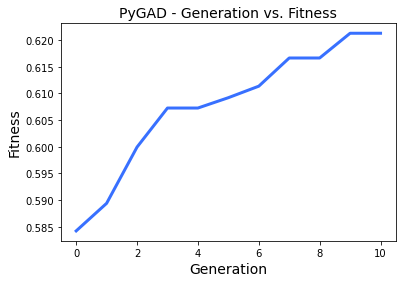

Parameters of the best solution : [11 58 37  5 54 36 53 45 46  2  3 44  4  4 44 34  6  6 44 44 38 38 13 44
 38 45 30 44 39 20  4 14 20 12 29 46 45 58 45  4 51 38  7 55 58  1 51 59
 33 40 61  1 48 37 37  2 36 20 32 23 46 28 22 16 13  4 34 51 29 22 22  5
 25  7 44 16 13 60 46 13 36 21 53 60  8 26 23 15 55 43 21 51  2  7 31  5
 12 40 42 53 63 57 41 61 54 63  6 32 17 24  1 40 20  3 28 63 17  3 29  2
  7 52 31 25 22  6  2 38 60  0 31  5 11 62 34 47 56 60 20  0 40 29  0 30
 28 27 22 22 15  1 31 51 27 28  2 15 57 56  6 45 54 58 17  8 61 53 16 61
  7 46 20 13 33 26 51 25  0 30 41 51 24 31 37 28 21 20 29  0 29 24 15 34
 11 41 11 23 61  1  5 25 16 17 28 45 49 32 31 62  5 58 47 46 57 37 44  7
 55  3 61 60 36 60 28 57  1 21 43 37 38 55 34 36  7 32 51 63  5  7 52 20
 48 20 28 61 40 24  0  0 41 62 30 45 61 15 52  7 28 17  9 33  4 21 54 27
 62 47 53 57 35  8 57 10  6 31 23 31 27 15 15 44 22 23  9 58 23  6  1 37
 27  0 46 29 41 38  9 17 25 28 30 46 28 39  2 14 62 51 32  3 37 23 37 51
 58 47 28 15 40 1

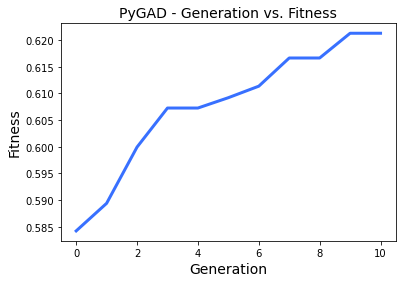

CPU times: user 442 ms, sys: 42.3 ms, total: 485 ms
Wall time: 597 ms


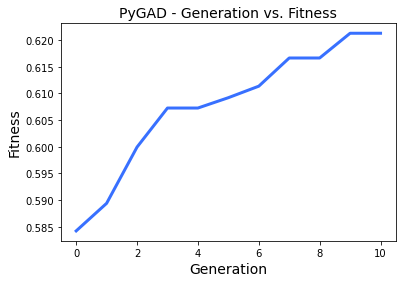

In [11]:
%%time

# Running the GA to optimize the parameters of the function.
ga_instance.run()

# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
seq_aa = ''.join([codon_to_int[x] for x in solution])
print("NT Sequence of the best solution : {seq_aa}".format(seq_aa=seq_aa))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# # prediction = numpy.sum(numpy.array(function_inputs)*solution) Replace
# print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

# Saving the GA instance.
 # The filename to which the instance is saved. The name is without extension.
ga_instance.save(filename=filename)

# Loading the saved GA instance.
loaded_ga_instance = pygad.load(filename=filename)
loaded_ga_instance.plot_result()